In [ ]:
df_with_out.columns

'''
df_with_out[cat_cols] = df_with_out[cat_cols].astype('object')
numerical_with_out = df_with_out.select_dtypes(include=['int64', 'float64'])

local_scaler = StandardScaler()
numerical_scaled_with_out = local_scaler.fit_transform(numerical_with_out)
numerical_scaled_with_out = pd.DataFrame(numerical_scaled_with_out, columns=numerical_with_out.columns)


df_no_out = df_with_out[df_with_out['OUTLIER'] == 0]
df_no_out[cat_cols] = df_no_out[cat_cols].astype('object')
numerical_no_out = df_no_out.select_dtypes(include=['int64', 'float64'])

numerical_scaled_no_out = local_scaler.fit_transform(numerical_no_out)
numerical_scaled_no_out = pd.DataFrame(numerical_scaled_no_out, columns=numerical_no_out.columns)
'''

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)
import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
def prepare_for_clustering(df, remove_outliers=True, with_indicators=True):
    cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

    orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
            'max_age_participants', 'n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
            'povertyPercentage', 'candidatevotes', 'totalvotes']

    if remove_outliers:
        df = df[df['OUTLIER'] == 0]

    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')#df[cat_cols] = df[cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        numerical_df = numerical_df[orig_num_cols]

    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_df)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_scaled


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, n_samples=1, sample_size=1000, k_min=2, k_max=10, initial_centroids=None, return_models=False):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    
    modelss = [[], []]
    scoress = [[], []]
    sampless = [[], []]

    for i in range(0, k_max):
        modelss.append([])
        scoress.append([])
        sampless.append([])
        
    for i in range(0, n_samples):
        sample = numeric_df.sample(n=sample_size).copy()
        for k in tqdm(range(k_min, k_max+1)):
            if initial_centroids is None:
                model = KMeans(n_clusters=k, n_init=10)
            else:
                model = KMeans(n_clusters=k, n_init=10, init=initial_centroids)
            labels = model.fit_predict(sample)
            score = silhouette_score(sample, labels)

            if return_models:
                modelss[k].append(model)
                scoress[k].append(score)
                sampless[k].append(sample)

    return modelss, scoress, sampless


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    # Combine items and scores using zip
    combined = list(zip(columns, max_scores))

    # Sort the combined list based on scores in descending order
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)

    # Extract the sorted items
    sorted_cols = [item for item, score in sorted_combined]
    # Extract the sorted scores
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced


def show_scores(scoress, k_min, k_max):
    mean_scores = []
    for k in range(k_min, k_max+1):
        mean_scores.append(np.mean(np.array(scoress[k])))

    max_scores = []
    for k in range(k_min, k_max+1):
        max_scores.append(np.max(np.array(scoress[k])))

    k_values = np.arange(k_min, k_max+1)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

    axes[0].plot(k_values, mean_scores)
    axes[0].set_title('Mean scores')
    axes[0].set_xlabel('Number of clusters')
    axes[0].set_ylabel('Silhouette score')

    axes[1].plot(k_values, max_scores)
    axes[1].set_title('Max scores')
    axes[1].set_xlabel('Number of clusters')
    axes[1].set_ylabel('Silhouette score')

    plt.tight_layout()
    plt.show()

    print(f'Max score: {np.max(max_scores)} (for k={np.argmax(max_scores)+k_min})')

    return mean_scores, max_scores

In [4]:
df = pd.read_csv('./dataset/data/final_clean2.csv')

df_with_out = prepare_for_clustering(df, remove_outliers=False, with_indicators=True)
df_no_out = prepare_for_clustering(df, remove_outliers=True, with_indicators=True)
df_with_out_orig = prepare_for_clustering(df, remove_outliers=False, with_indicators=False)
df_no_out_orig = prepare_for_clustering(df, remove_outliers=True, with_indicators=False)

print(f'Dataset dimentions: {df.shape}')
print(f'Dataset dimentions with ouliers, with only numerical cols, with indicators: {df_with_out.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df_no_out.shape}')
print(f'Dataset dimentions with ouliers, with only numerical cols, without indicators: {df_with_out_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_no_out_orig.shape}')

Dataset dimentions: (235219, 61)
Dataset dimentions with ouliers, with only numerical cols, with indicators: (235219, 51)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 51)
Dataset dimentions with ouliers, with only numerical cols, without indicators: (235219, 19)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 19)


## Experiments on the not augmented dataset:

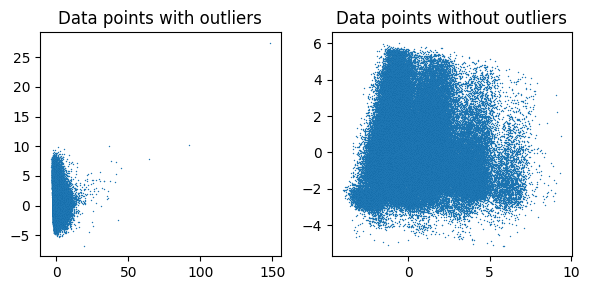

In [9]:
pca_with_out = perform_PCA(df=df_with_out_orig, n_components=2)
pca_no_out = perform_PCA(df=df_no_out_orig, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_with_out[:, 0], pca_with_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points with outliers')

plt.subplot(1, 2, 2)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

#### K-means on the full (not augmented) dataset with outliers

In [10]:
k_min = 2
k_max = 10

modelss, scoress, sampless = k_means(df_with_out_orig, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


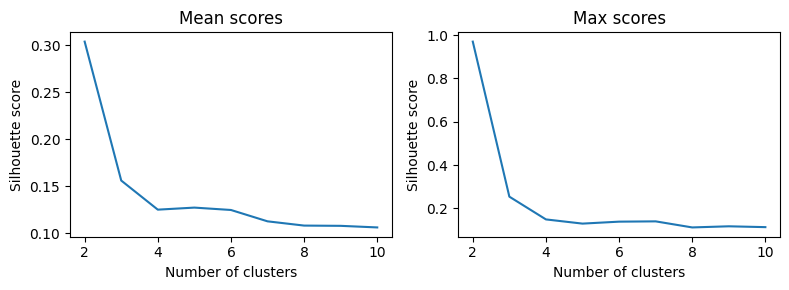

Max score: 0.9699139378882569 (for k=2)


In [16]:
mean_scores, max_scores = show_scores(scoress, k_min, k_max)

In [18]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(max_scores)+k_min

best_model_index = np.argmax(scoress[best_k]).astype(np.int64)
best_model = modelss[best_k][best_model_index]

sample = df_with_out_orig.sample(n=50000).copy()

labels = best_model.predict(sample)
score = silhouette_score(sample, labels)

print(f'Best model score: {score}\n')

print('Best model centroids:\n')
for c in best_model.cluster_centers_:
    print(f'{c}\n')

2
Best model score: 0.9699926943084037


In [19]:
k = mean_scores.index(max(mean_scores)) + k_min

modelss, scoress, sampless = k_means(df_with_out_orig, n_samples=4, sample_size=50000, k_min=k, k_max=k, return_models=True)

best_model_index = np.argmax(scoress[k]).astype(np.int64)
best_model = modelss[k][best_model_index]
best_model_score = scoress[k][best_model_index]

print(f'Best model score: {best_model_score}\n')

print('Best model centroids:\n')
for c in best_model.cluster_centers_:
    print(f'{c}\n')

  0%|          | 0/1 [00:00<?, ?it/s]

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
  0%|          | 0/1 [00:00<?, ?it/s]/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
  0%|          | 0/1 [00:00<?, ?it/s]/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
  0%|          | 0/1 [00:00<?, ?it/s]/home/claudia/code/DataMining/DataMining-20

Best score: 0.9524658915773271


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


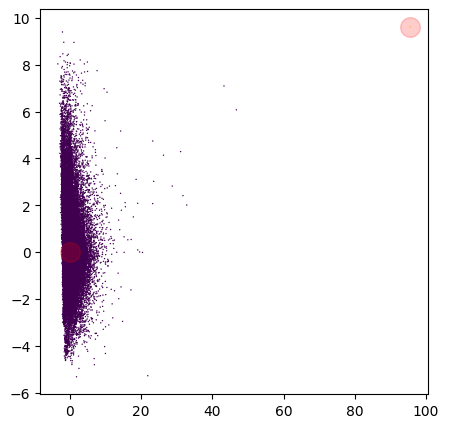

In [21]:
best_model_samples = sampless[k][best_model_index]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(5, 5))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

In [31]:
points_in_cluster_0 = np.count_nonzero(best_model.labels_ == 0)
points_in_cluster_1 = np.count_nonzero(best_model.labels_ == 1)

print(f'Points in cluster 0: {points_in_cluster_0}')
print(f'Points in cluster 1: {points_in_cluster_1}')

Points in cluster 0: 49999
Points in cluster 1: 1


#### K-means on the full (not augmented) dataset without outliers

In [35]:
k_min = 2
k_max = 10

modelss, scoress, sampless = k_means(df_no_out_orig, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

100%|██████████| 9/9 [00:25<00:00,  2.85s/it]


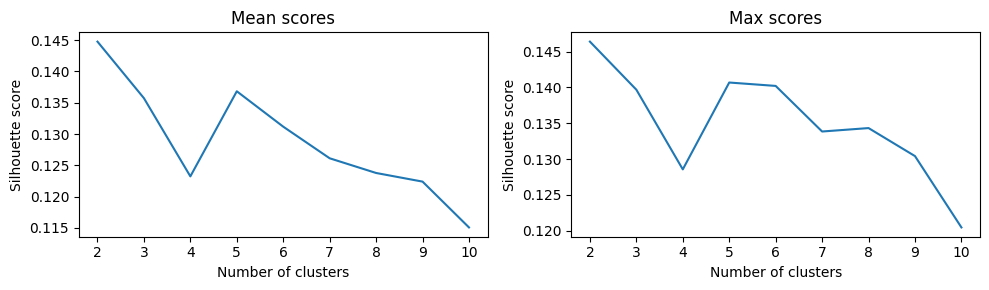

Max score: 0.14640934337748301 (for k=2)


In [40]:
mean_scores, max_scores = show_scores(scoress, k_min, k_max)

In [44]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(max_scores)+k_min

best_model_index = np.argmax(scoress[best_k]).astype(np.int64)
best_model = modelss[best_k][best_model_index]

sample = df_no_out_orig.sample(n=50000).copy()

labels = best_model.predict(sample)
score = silhouette_score(sample, labels)

print(f'Best model score: {score}\n')

print('Best model centroids:\n')
for c in best_model.cluster_centers_:
    print(f'{c}\n')

Best model score: 0.1250600871308233

Best model centroids:

[ 0.05880318  0.03254626  0.01563578 -0.03307114 -0.07657026  0.
  0.11625359 -0.71412219 -0.61386105 -0.18969201 -0.07413822 -0.16408695
 -0.15581931 -0.40328887 -0.71560967  0.04581107 -0.06808363  0.02545304
  0.02854446]

[-0.10738449 -0.01381626 -0.03361576  0.03935105  0.10731924  0.
 -0.16549392  1.02840864  0.89754114  0.24593861  0.10984451  0.22603263
  0.22571967  0.58695367  1.03122983 -0.04854113  0.09794571 -0.03855446
 -0.06086483]



In [46]:
k = mean_scores.index(max(mean_scores)) + k_min

modelss, scoress, sampless = k_means(df_no_out_orig, n_samples=4, sample_size=50000, k_min=k, k_max=k, return_models=True)

best_model_index = np.argmax(scoress[k]).astype(np.int64)
best_model = modelss[k][best_model_index]
best_model_score = scoress[k][best_model_index]

print(f'Best model score: {best_model_score}\n')

print('Best model centroids:\n')
for c in best_model.cluster_centers_:
    print(f'{c}\n')

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:43<00:00, 43.03s/it]

Best model score: []

Best model centroids:

[-0.08055001 -0.03532637 -0.03157324  0.04607744  0.11553707  0.
 -0.17115292  1.03094672  0.88765648  0.26832771  0.12044671  0.22806622
  0.2250233   0.58038915  1.03192083 -0.06262223  0.09805548 -0.0517111
 -0.05846915]

[ 0.06200711  0.0205058   0.02681931 -0.0264922  -0.07546268  0.
  0.11511244 -0.71313604 -0.62026799 -0.17477581 -0.07914233 -0.15791711
 -0.16015786 -0.40135563 -0.71496773  0.03717418 -0.06662854  0.0208552
  0.03165766]



/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


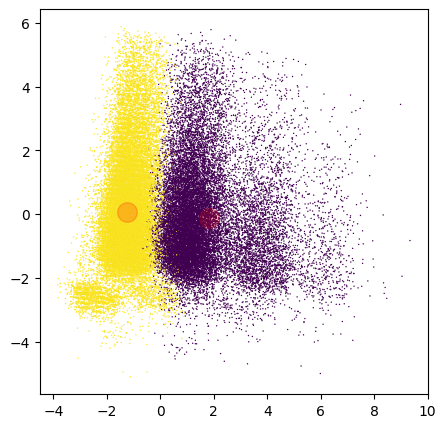

In [57]:
best_model_samples = sampless[k][best_model_index]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(5, 5))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

points_in_cluster_0 = np.count_nonzero(best_model.labels_ == 0)
points_in_cluster_1 = np.count_nonzero(best_model.labels_ == 1)

print(f'Points in cluster 0: {points_in_cluster_0}')
print(f'Points in cluster 1: {points_in_cluster_1}')

#### Feature reduction using variance

In [59]:
reduced_with_out_orig_var = features_reduction_var(df_with_out_orig, variance_threshold=1)
reduced_no_out_orig_var = features_reduction_var(df_no_out_orig, variance_threshold=1)
print('Survived columns (with outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_with_out_orig_var.columns)}')
print(reduced_with_out_orig_var.columns)
print('\nSurvived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_orig_var.columns)}')
print(reduced_no_out_orig_var.columns)

Survived columns (with outliers):----------------------------------------------
n_cols = 19
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
       'povertyPercentage', 'candidatevotes', 'totalvotes'],
      dtype='object')

Survived columns (without outliers):----------------------------------------------
n_cols = 18
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes'],
      dtype='object')


#### Feature reduction using correlation

In [60]:
reduced_with_out_orig = features_reduction_corr(reduced_with_out_orig_var, correlation_threshold=0.3)
reduced_no_out_orig = features_reduction_corr(reduced_no_out_orig_var, correlation_threshold=0.3)
print('Survived columns (with outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_with_out_orig.columns)}')
print(reduced_with_out_orig.columns)
print('\nSurvived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_orig.columns)}')
print(reduced_no_out_orig.columns)

Survived columns (with outliers):----------------------------------------------
n_cols = 9
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_child',
       'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured',
       'timestamp'],
      dtype='object')

Survived columns (without outliers):----------------------------------------------
n_cols = 7
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_females', 'n_killed', 'timestamp'],
      dtype='object')


#### K-means on the reduced (not augmented) dataset without outliers

In [61]:
k_min = 2
k_max = 10

modelss, scoress, sampless = k_means(reduced_no_out_orig, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:23<00:00,  2.64s/it]


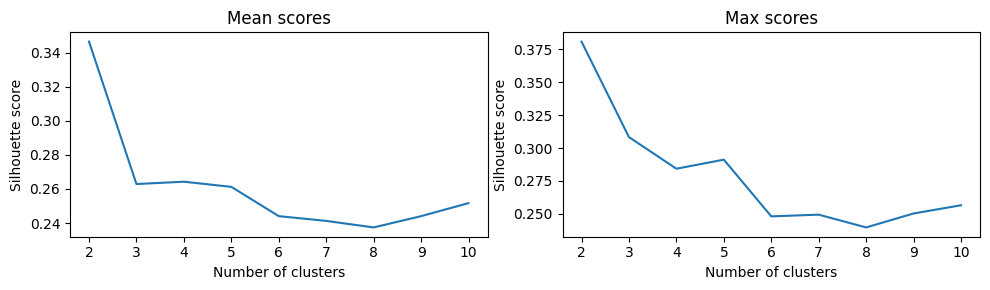

Max score: 0.38077033345757844 (for k=2)


In [62]:
mean_scores, max_scores = show_scores(scoress, k_min, k_max)

In [63]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(max_scores)+k_min

best_model_index = np.argmax(scoress[best_k]).astype(np.int64)
best_model = modelss[best_k][best_model_index]

sample = reduced_no_out_orig.sample(n=50000).copy()

labels = best_model.predict(sample)
score = silhouette_score(sample, labels)

print(f'Best model score: {score}\n')

print('Best model centroids:\n')
for c in best_model.cluster_centers_:
    print(f'{c}\n')

Best model score: 0.37803034519131606

Best model centroids:

[ 0.01809556  0.00628174  0.07423831 -0.27318702  0.00118985 -0.00274777
 -0.00071109]

[-0.03272762 -0.05562245 -0.84402535  3.660496    0.01036349 -0.01788588
 -0.05548919]



In [64]:
k = mean_scores.index(max(mean_scores)) + k_min

modelss, scoress, sampless = k_means(reduced_no_out_orig, n_samples=4, sample_size=50000, k_min=k, k_max=k, return_models=True)

best_model_index = np.argmax(scoress[k]).astype(np.int64)
best_model = modelss[k][best_model_index]
best_model_score = scoress[k][best_model_index]

print(f'Best model score: {best_model_score}\n')

print('Best model centroids:\n')
for c in best_model.cluster_centers_:
    print(f'{c}\n')

100%|██████████| 1/1 [00:44<00:00, 44.74s/it]

Best model score: 0.3795481867951715

Best model centroids:

[ 0.00150692  0.00553983  0.05721577 -0.27318702 -0.00051768 -0.00191491
  0.00187286]

[ 0.04344586  0.04193839 -0.8474109   3.660496   -0.00745472 -0.06089839
 -0.05625287]



/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


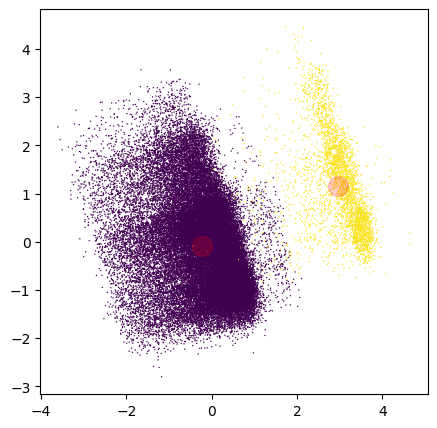

Points in cluster 0: 46517
Points in cluster 1: 3483


In [65]:
best_model_samples = sampless[k][best_model_index]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(5, 5))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

points_in_cluster_0 = np.count_nonzero(best_model.labels_ == 0)
points_in_cluster_1 = np.count_nonzero(best_model.labels_ == 1)

print(f'Points in cluster 0: {points_in_cluster_0}')
print(f'Points in cluster 1: {points_in_cluster_1}')

#### K-means on the full augmented dataset without outliers

In [66]:
k_min = 2
k_max = 10

modelss, scoress, sampless = k_means(df_no_out, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

100%|██████████| 9/9 [00:28<00:00,  3.18s/it]


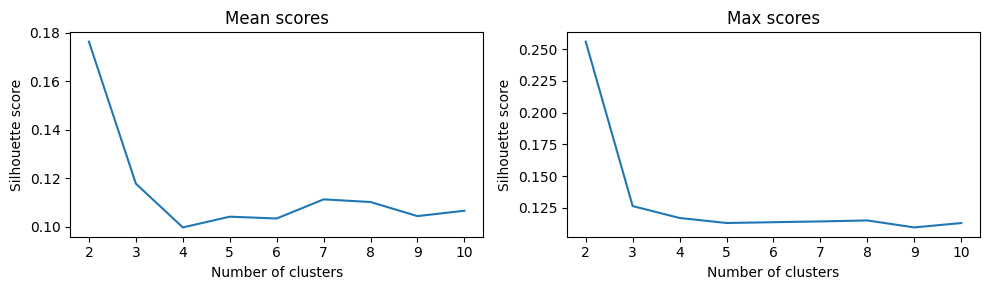

Max score: 0.2558701468312898 (for k=2)


In [67]:
mean_scores, max_scores = show_scores(scoress, k_min, k_max)

In [68]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(max_scores)+k_min

best_model_index = np.argmax(scoress[best_k]).astype(np.int64)
best_model = modelss[best_k][best_model_index]

sample = df_no_out.sample(n=50000).copy()

labels = best_model.predict(sample)
score = silhouette_score(sample, labels)

print(f'Best model score: {score}\n')

print('Best model centroids:\n')
for c in best_model.cluster_centers_:
    print(f'{c}\n')

Best model score: 0.25178384012315136

Best model centroids:

[ 0.0169715   0.00325557  0.05192938  0.04934479  0.0424966   0.
 -0.27064916  0.08248934 -0.00749901 -0.0011179  -0.00570948 -0.03277159
  0.00573999  0.01737747 -0.00816622  0.00093738 -0.02577948 -0.00214532
  0.00775161  0.01628193 -0.00159634  0.00159634  0.         -0.25520932
  0.25520932 -0.00432042 -0.02534465  0.01779051  0.01442734  0.04401409
  0.04123228  0.03527918  0.00252275  0.00774314  0.         -0.20973348
  0.03362527  0.00087173  0.00251402 -0.00263269  0.0165679  -0.01636386
 -0.01941856  0.01638921  0.00541065 -0.00541065 -0.02489642 -0.00792407
 -0.00105605  0.03451872  0.00962374]

[ 0.05128484  0.03634724 -0.85173366 -0.82058879 -0.72047954  0.
  3.660496   -1.27301259 -0.08054332  0.05346376 -0.06599581  0.17219954
  0.11562114 -0.24770479 -0.05628072 -0.06262739  0.01181658 -0.01738267
 -0.02696343 -0.0230984  -0.05751822  0.05751822  0.          3.50865824
 -3.50865824 -0.0854884   0.22186057  0

In [69]:
k = mean_scores.index(max(mean_scores)) + k_min

modelss, scoress, sampless = k_means(df_no_out, n_samples=4, sample_size=50000, k_min=k, k_max=k, return_models=True)

best_model_index = np.argmax(scoress[k]).astype(np.int64)
best_model = modelss[k][best_model_index]
best_model_score = scoress[k][best_model_index]

print(f'Best model score: {best_model_score}\n')

print('Best model centroids:\n')
for c in best_model.cluster_centers_:
    print(f'{c}\n')

100%|██████████| 1/1 [00:44<00:00, 44.77s/it]

Best model score: 0.2540430997332395

Best model centroids:

[ 0.00173986 -0.00527333  0.06603223  0.06336809  0.05590715  0.
 -0.26802704  0.09143655  0.00053928  0.00352299 -0.00321519 -0.00982696
 -0.00309312  0.01446795  0.00223985  0.00600326 -0.00727985  0.00154591
  0.00455612  0.00103453 -0.00200529  0.00200529  0.         -0.25415225
  0.25415225  0.00062971 -0.015387    0.00230843  0.01508161  0.05905636
  0.0560236   0.04882291  0.00678512  0.00563468  0.         -0.20888831
  0.03576925  0.0021909   0.00093189  0.00487702  0.00880038 -0.00824877
 -0.00961927  0.00562523  0.01046016 -0.01046016 -0.01368379 -0.00089115
  0.01548     0.00759254 -0.00522655]

[ 3.17263597e-02  2.91780218e-03 -8.38682399e-01 -8.15599290e-01
 -7.24540273e-01  0.00000000e+00  3.66049600e+00 -1.25857508e+00
 -3.21166026e-02 -1.73055442e-02 -8.77783428e-02  1.62512067e-01
  1.11336893e-01 -2.08851803e-01 -4.09832176e-02 -5.70464889e-02
 -6.53843716e-03 -2.95618254e-02 -6.17356205e-02  9.23698803e-03

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


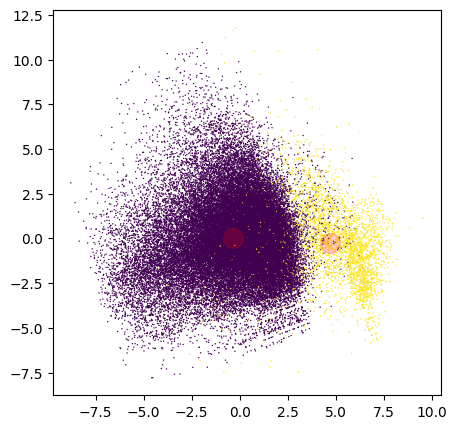

Points in cluster 0: 46503
Points in cluster 1: 3497


In [70]:
best_model_samples = sampless[k][best_model_index]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(5, 5))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

points_in_cluster_0 = np.count_nonzero(best_model.labels_ == 0)
points_in_cluster_1 = np.count_nonzero(best_model.labels_ == 1)

print(f'Points in cluster 0: {points_in_cluster_0}')
print(f'Points in cluster 1: {points_in_cluster_1}')

#### Features reduction using variance

In [71]:
reduced_with_out_var = features_reduction_var(df_with_out, variance_threshold=1)
reduced_no_out_var = features_reduction_var(df_no_out, variance_threshold=1)
print('Survived columns (with outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_with_out_var.columns)}')
print(reduced_with_out_var.columns)
print('\nSurvived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_var.columns)}')
print(reduced_no_out_var.columns)

Survived columns (with outliers):----------------------------------------------
n_cols = 51
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_child', 'n_participants_teen',
       'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
       'povertyPercentage', 'candidatevotes', 'totalvotes', 'state_population',
       'p_males', 'p_females', 'p_participants_child', 'p_participants_teen',
       'p_participants_adult', 'p_killed', 'p_injured', 'p_arrested',
       'p_unharmed', 'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_child',
       'month_cd_ratio_participants_teen', 'month_cd_ratio_participants_adult',
       'month_cd_ratio_killed', 'month_cd_ratio

#### Feature reduction using correlation

In [72]:
reduced_with_out = features_reduction_corr(reduced_with_out_var, correlation_threshold=0.3)
reduced_no_out = features_reduction_corr(reduced_no_out_var, correlation_threshold=0.3)
print('Survived columns (with outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_with_out.columns)}')
print(reduced_with_out.columns)
print('\nSurvived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out.columns)}')
print(reduced_no_out.columns)

Survived columns (with outliers):----------------------------------------------
n_cols = 10
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_child',
       'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured',
       'timestamp', 'month_cd_votes_incidents'],
      dtype='object')

Survived columns (without outliers):----------------------------------------------
n_cols = 8
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_females', 'n_killed', 'timestamp', 'month_cd_ratio_males'],
      dtype='object')


#### K-means on the reduced (augmented) dataset without outliers

In [73]:
k_min = 2
k_max = 10

modelss, scoress, sampless = k_means(reduced_no_out, n_samples=10, sample_size=10000, k_min=k_min, k_max=k_max, return_models=True)

100%|██████████| 9/9 [00:22<00:00,  2.46s/it]


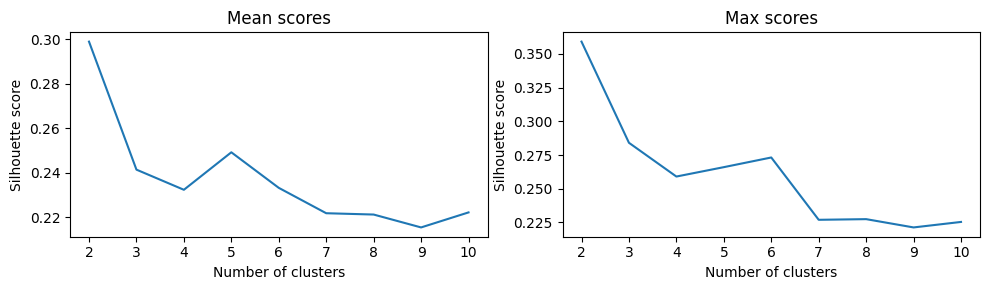

Max score: 0.3590644106179805 (for k=2)


In [74]:
mean_scores, max_scores = show_scores(scoress, k_min, k_max)

In [75]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(max_scores)+k_min

best_model_index = np.argmax(scoress[best_k]).astype(np.int64)
best_model = modelss[best_k][best_model_index]

sample = reduced_no_out.sample(n=50000).copy()

labels = best_model.predict(sample)
score = silhouette_score(sample, labels)

print(f'Best model score: {score}\n')

print('Best model centroids:\n')
for c in best_model.cluster_centers_:
    print(f'{c}\n')

Best model score: 0.35557861829187604

Best model centroids:

[ 2.74140520e-02 -8.48969550e-03 -8.90328724e-01  3.66049600e+00
  2.79913334e-03 -9.54556773e-02 -2.49987540e-02 -5.00535012e-02]

[ 0.01870064  0.02784252  0.04993809 -0.27318702  0.01328424 -0.01226657
 -0.01595487 -0.01201254]



In [76]:
k = mean_scores.index(max(mean_scores)) + k_min

modelss, scoress, sampless = k_means(reduced_no_out, n_samples=4, sample_size=50000, k_min=k, k_max=k, return_models=True)

best_model_index = np.argmax(scoress[k]).astype(np.int64)
best_model = modelss[k][best_model_index]
best_model_score = scoress[k][best_model_index]

print(f'Best model score: {best_model_score}\n')

print('Best model centroids:\n')
for c in best_model.cluster_centers_:
    print(f'{c}\n')

100%|██████████| 1/1 [00:43<00:00, 43.53s/it]

Best model score: 0.35502974031588114

Best model centroids:

[-0.01661684  0.01886947 -0.82762224  3.660496   -0.01772453 -0.05697716
 -0.05402353 -0.04263533]

[ 0.00519754  0.00235603  0.05305772 -0.27318702 -0.0031549  -0.00377223
  0.00922792  0.00520611]



/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


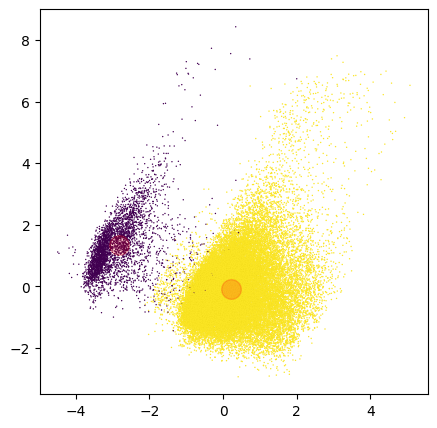

Points in cluster 0: 3531
Points in cluster 1: 46469


In [77]:
best_model_samples = sampless[k][best_model_index]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(5, 5))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

points_in_cluster_0 = np.count_nonzero(best_model.labels_ == 0)
points_in_cluster_1 = np.count_nonzero(best_model.labels_ == 1)

print(f'Points in cluster 0: {points_in_cluster_0}')
print(f'Points in cluster 1: {points_in_cluster_1}')